In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linalg as LA
from math import pi

In [ ]:
x_grid = np.linspace(0, 1, 21)
t_grid = np.linspace(0, 1, 21)

x = torch.from_numpy(x_grid)
t = torch.from_numpy(t_grid)

grid = torch.cartesian_prod(x, t).float()

In [ ]:
# 1. u(x, 0) = sin(pi*x) |==> t = 0
b1 = torch.cartesian_prod(x, torch.from_numpy(np.array([0], dtype=np.float64))).float()
u_b1 = torch.sin(torch.pi * b1[:, 0])

# 2. u_t(x, 0) = 0 |==> t = 0
b2 = torch.cartesian_prod(x, torch.from_numpy(np.array([0], dtype=np.float64))).float()
u_b2 = torch.from_numpy(np.zeros(len(b2), dtype=np.float64))

# 3. u(0, t) = 0 |==> x = 0
b3 = torch.cartesian_prod(torch.from_numpy(np.array([0], dtype=np.float64)), t).float()
u_b3 = torch.from_numpy(np.zeros(len(b3), dtype=np.float64))

# 4. u(1, t) = 0 |==> x = 1
b4 = torch.cartesian_prod(torch.from_numpy(np.array([1], dtype=np.float64)), t).float()
u_b4 = torch.from_numpy(np.zeros(len(b4), dtype=np.float64))

u_b_all = [[b1, u_b1], [b2, u_b2], [b3, u_b3], [b4, u_b4]]

In [ ]:
neurons = 100

model = torch.nn.Sequential(
            torch.nn.Linear(2, neurons),
            torch.nn.Tanh(),
            torch.nn.Linear(neurons, neurons),
            torch.nn.Tanh(),
            torch.nn.Linear(neurons, 1)
            )

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [ ]:
def nn_autograd(model, points, var=0, axis=[0]):
    points.requires_grad = True
    fi = model(points)[:, var].sum(0)
    for ax in axis:
        grads, = torch.autograd.grad(fi, points, create_graph=True)
        fi = grads[:, ax].sum()
    gradient_full = grads[:, axis[-1]].reshape(-1, 1)
    return gradient_full

In [ ]:
def wave_equation(grid, a=1/4):
    u_xx = nn_autograd(model, grid, axis=[0, 0])
    u_tt = nn_autograd(model, grid, axis=[1, 1])
    f = a * u_tt - u_xx
    return f

In [ ]:
def norm_loss(operator):
    return torch.sum(torch.mean((operator) ** 2, 0))

In [ ]:
def MSE_loss(u_true, u_pred):
    return torch.mean((u_true - u_pred) ** 2)

In [ ]:
# Dirichlet BC

def Dir_BC_loss(lst_bnd):

#     b_loss_1 = torch.mean((model(lst_bnd[0][0]) - lst_bnd[0][1]) ** 2)
#     b_loss_2 = torch.mean((nn_autograd(model, lst_bnd[1][0], axis=[1]) - lst_bnd[1][1]) ** 2)
#     b_loss_3 = torch.mean((model(lst_bnd[2][0]) - lst_bnd[2][1]) ** 2)
#     b_loss_4 = torch.mean((model(lst_bnd[3][0]) - lst_bnd[3][1]) ** 2)
#     b_loss = b_loss_1 + b_loss_2 + b_loss_3 + b_loss_4

    b_loss_1 = MSE_loss(model(lst_bnd[0][0]), lst_bnd[0][1])
    b_loss_2 = MSE_loss(nn_autograd(model, lst_bnd[1][0], axis=[1]), lst_bnd[1][1])
    b_loss_3 = MSE_loss(model(lst_bnd[2][0]), lst_bnd[2][1])
    b_loss_4 = MSE_loss(model(lst_bnd[3][0]), lst_bnd[3][1])
    b_loss = b_loss_1 + b_loss_2 + b_loss_3 + b_loss_4

    return b_loss

In [ ]:
# Neumann BC

def Neum_BC_loss(lst_bnd):

    b_loss_1 = torch.mean((model(lst_bnd[0][0]) - lst_bnd[0][1]) ** 2)
    b_loss_2 = torch.mean((nn_autograd(model, lst_bnd[1][0], axis=[1]) - lst_bnd[1][1]) ** 2)
    b_loss_3 = torch.mean((nn_autograd(model, lst_bnd[2][0]) - lst_bnd[2][1]) ** 2)
    b_loss_4 = torch.mean((nn_autograd(model, lst_bnd[3][0]) - lst_bnd[3][1]) ** 2)
    b_loss = b_loss_1 + b_loss_2 + b_loss_3 + b_loss_4

    # b_loss_1 = MSE_loss(model(lst_bnd[0][0]), lst_bnd[0][1])
    # b_loss_2 = MSE_loss(nn_autograd(model, lst_bnd[1][0], axis=[1]), lst_bnd[1][1])
    # b_loss_3 = MSE_loss(nn_autograd(model, lst_bnd[2][0]), lst_bnd[2][1])
    # b_loss_4 = MSE_loss(nn_autograd(model, lst_bnd[3][0]), lst_bnd[3][1])
    # b_loss = b_loss_1 + b_loss_2 + b_loss_3 + b_loss_4

    return b_loss

In [ ]:
lu, lb = [100, 1]

In [ ]:
epochs = 10000
for i in range(epochs + 1):
    optimizer.zero_grad()
    loss = lu * norm_loss(wave_equation(grid)) + lb * Dir_BC_loss(u_b_all)
    # loss = lu * norm_loss(wave_equation(grid)) + lb * Neum_BC_loss(u_b_all)
    loss.backward()
    optimizer.step()
    if i % 500 == 0:
        print(f"Epoch {i}/{epochs}: Loss = {loss.item()}")

Epoch 0/10000: Loss = 0.7004840002623018
Epoch 500/10000: Loss = 0.2102192232008715
Epoch 1000/10000: Loss = 0.18010692529076971
Epoch 1500/10000: Loss = 0.1940452682585519
Epoch 2000/10000: Loss = 0.1760916007340457
Epoch 2500/10000: Loss = 0.1696852161999628
Epoch 3000/10000: Loss = 0.1853059171448689
Epoch 3500/10000: Loss = 0.16833273615176406
Epoch 4000/10000: Loss = 0.16903200286483303
Epoch 4500/10000: Loss = 0.47842620907115524
Epoch 5000/10000: Loss = 0.1654137005103767
Epoch 5500/10000: Loss = 0.16171014396279343
Epoch 6000/10000: Loss = 0.19156049813212955
Epoch 6500/10000: Loss = 0.16316740036239538
Epoch 7000/10000: Loss = 0.1626297949262434
Epoch 7500/10000: Loss = 0.15842086997380225
Epoch 8000/10000: Loss = 0.1669528365742894
Epoch 8500/10000: Loss = 0.19299741454572647
Epoch 9000/10000: Loss = 0.1538066125216242
Epoch 9500/10000: Loss = 0.15160064000912524
Epoch 10000/10000: Loss = 0.15162093535605117


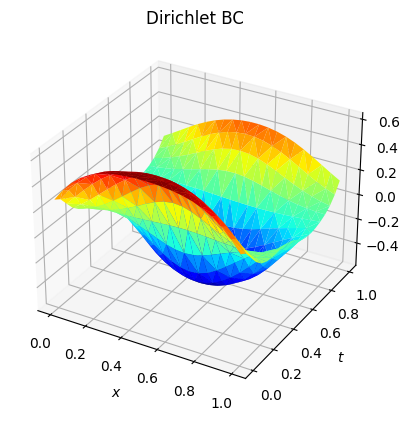

In [ ]:
# Dirichlet BC

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = grid[:, 0].detach().numpy().reshape(-1)
ys = grid[:, 1].detach().numpy().reshape(-1)
zs = model(grid).detach().numpy().reshape(-1)

ax.plot_trisurf(xs, ys, zs, cmap=cm.jet, linewidth=0.2, alpha=1)

ax.set_title("Dirichlet BC")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

plt.show()

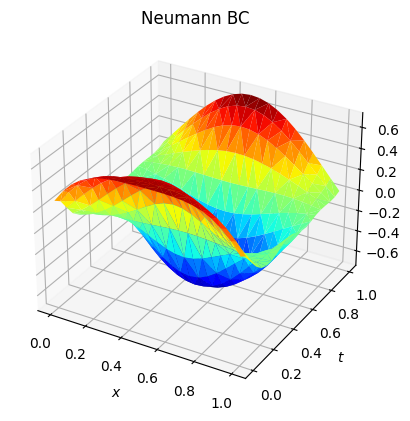

In [ ]:
# Neumann BC

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = grid[:, 0].detach().numpy().reshape(-1)
ys = grid[:, 1].detach().numpy().reshape(-1)
zs = model(grid).detach().numpy().reshape(-1)

ax.plot_trisurf(xs, ys, zs, cmap=cm.jet, linewidth=0.2, alpha=1)

ax.set_title("Neumann BC")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

plt.show()

# Physics-informed DeepONet

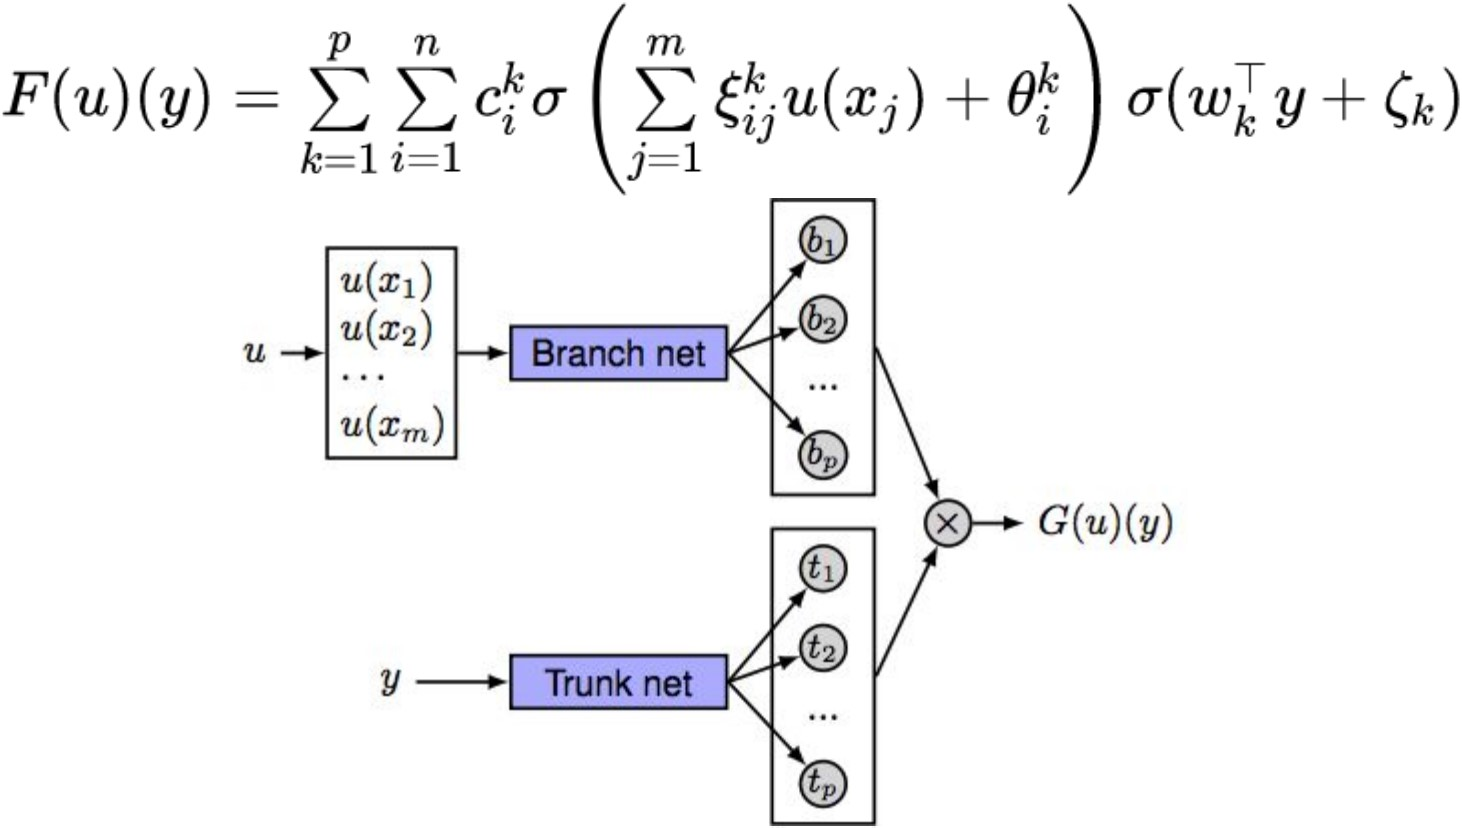

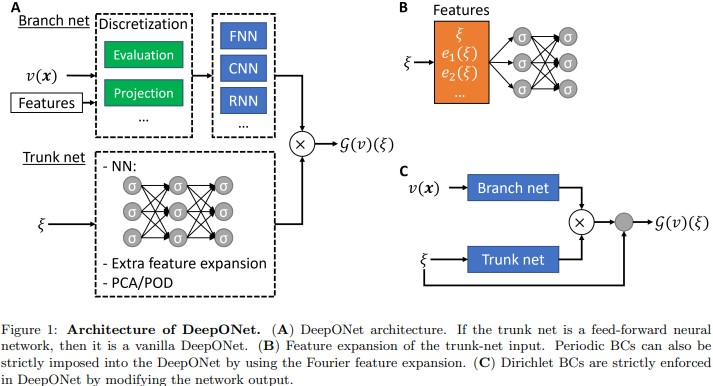

In [ ]:
# Implement a torch module for two inputs
class DeepONet(nn.Module):
    def __init__(self, neurons=40, in1=1, in2=1, output_neurons=20):
        super(DeepONet, self).__init__()
        self.neurons = neurons
        self.in1 = in1
        self.in2 = in2
        self.output_neurons = output_neurons
        self.b = torch.nn.parameter.Parameter(torch.tensor(0.0))
        self.b1 = self._branch_one()
        self.b2 = self._branch_two()

    def _branch_one(self):
        b1 = nn.Sequential(
            nn.Linear(self.in1, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons),
        )
        return b1

    def _branch_two(self):
        b2 = nn.Sequential(
            nn.Linear(self.in2, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons),
        )
        return b2

    def forward(self, x1, x2):
        x1 = self.b1(x1)
        x2 = self.b2(x2)
        x = torch.einsum("bi,bi->b", x1, x2)
        x = torch.unsqueeze(x, 1)
        x += self.b
        return x

In [ ]:
m = 100
n = 110

In [ ]:
x0 = np.linspace(0, 1, m)

In [ ]:
model_DeepONet = DeepONet(in1=m)  # neurons=40, in1=1, in2=1, output_neurons=20
model_DeepONet

DeepONet(
  (b1): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
  (b2): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=20, bias=True)
  )
)

# DeepONet Training

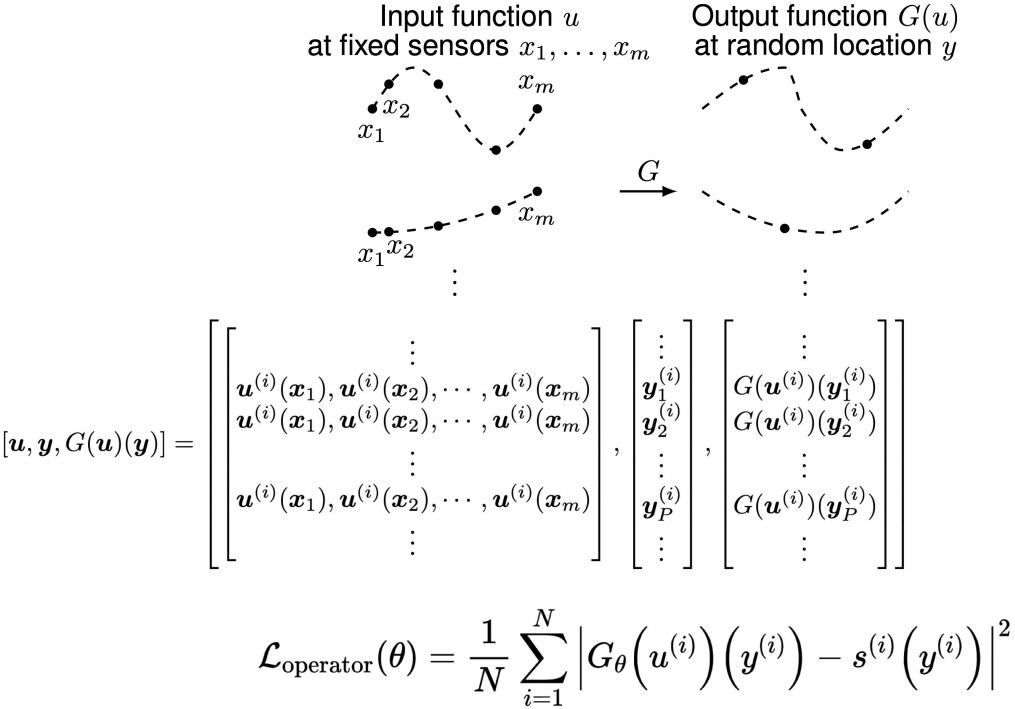